In [2]:
import os
import time
import pickle
import pandas as pd
import numpy as np
import json
import itertools

from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

#!pip install scikit-learn==0.20.3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

!pip install mne==0.22.0
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore

!pip install fooof
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

     |████████████████████████████████| 6.9 MB 5.2 MB/s 
     |████████████████████████████████| 112 kB 5.2 MB/s 


In [3]:
import gc
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

# 加载DEAP数据集
对 32 名参与者进行了脑电图（EEG）和外周生理信号的记录，他们在观看 40 个音乐视频的过程中完成了这些记录。参与者对每个视频进行了评分。数据被降采样（至 128Hz）、预处理并以 Python 编程语言的压缩格式进行分割。

In [ ]:
# Function to load data from each participant file
def read_eeg_signal_from_file(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    p = x.load()
    return p

In [ ]:
# Load only 22/32 participants with frontal videos recorded
files = []
# for n in range(1, 23): 
for n in range(1, 32): 
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)
print(files)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


每个参与者文件包含两个数组：一个“数据”数组（40 个试验×40 个通道×8064 个数据）和一个“标签”数组（40 个试验×4 个主观评价：愉悦度、唤醒度、支配度、喜爱度）。我们将这些数据文件合并成两个新的数组，包含 880 个试验，适用于 22/32 名参与者（这些参与者有录制的前额区视频）。

In [ ]:
# 22x40 = 880 trials for 22 participants
trials = len(files)*40
print(f"There are {trials} trials")
labels = []
data = []

for i in files:
  filename = "gdrive/MyDrive/study/22997/EEG-based-emotion-analysis-using-DEAP-dataset-for-Supervised-Machine-Learning/data/s" + i + ".dat"
  trial = read_eeg_signal_from_file(filename)
  labels.append(trial['labels'])
  data.append(trial['data'])

# Re-shape arrays into desired shapes
labels = np.array(labels)
labels = labels.flatten()
labels = labels.reshape(trials, 4)

data = np.array(data)
data = data.flatten()
data = data.reshape(trials, 40, 8064)

There are 1240 trials


In [ ]:
# Double-check the new arrays
print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data

Labels:  (1240, 4)
Data:  (1240, 40, 8064)


# 探索和预处理数据

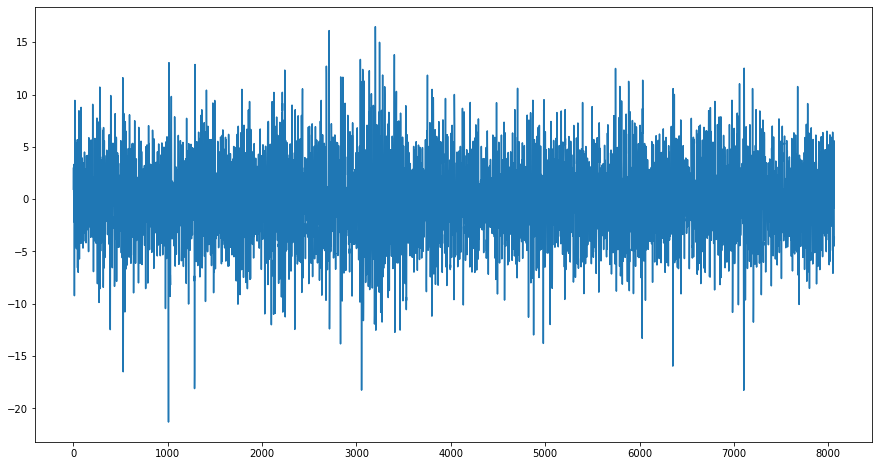

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(data[0][0])

## 标签

#### 获取Valence和Arousal
Valence描述的是一种情绪是积极还是消极的程度，而Arousal则指的是其强度，即所伴随的情绪状态的强度。

In [ ]:
# Only extract Valence and Arousal ratings
df_label_ratings = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1]})
print(df_label_ratings.describe())

           Valence      Arousal
count  1240.000000  1240.000000
mean      5.252435     5.144210
std       2.136497     2.031844
min       1.000000     1.000000
25%       3.800000     3.680000
50%       5.040000     5.165000
75%       7.050000     6.940000
max       9.000000     9.000000


In [ ]:
print(df_label_ratings.head(15))

    Valence  Arousal
0      7.71     7.60
1      8.10     7.31
2      8.58     7.54
3      4.94     6.01
4      6.96     3.92
5      8.27     3.92
6      7.44     3.73
7      7.32     2.55
8      4.04     3.29
9      1.99     4.86
10     2.99     2.36
11     2.71     2.77
12     1.95     3.12
13     4.18     2.24
14     3.17     8.08


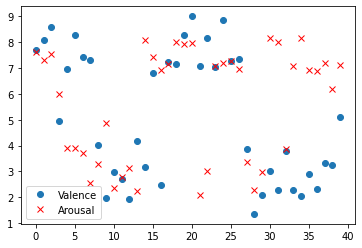

In [ ]:
# Plot the first 40 data rows (first participant)
df_label_ratings.iloc[0:40].plot(style=['o','rx'])

#### 转化为四种情绪状态
Valence和Arousal的组合可以转化为四种情绪状态：High Arousal Positive Valence (Excited, Happy), Low Arousal Positive Valence (Calm, Relaxed), High Arousal Negative Valence (Angry, Nervous), Low Arousal Negative Valence (Sad, Bored)

In [ ]:
# High Arousal Positive Valence dataset
df_hahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Positive Valence dataset
df_lahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]
# High Arousal Negative Valence dataset
df_halv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Negative Valence dataset
df_lalv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]

In [ ]:
# Check nummber of trials per each group
print("Positive Valence:", str(len(df_hahv) + len(df_lahv)))
print("Negative Valence:", str(len(df_halv) + len(df_lalv)))
print("High Arousal:", str(len(df_hahv) + len(df_halv)))
print("Low Arousal:", str(len(df_lahv) + len(df_lalv)))

Positive Valence: 661
Negative Valence: 579
High Arousal: 620
Low Arousal: 620


In [ ]:
# Check nummber of trials per each group
print("High Arousal Positive Valence:", str(len(df_hahv)))
print("Low Arousal Positive Valence:", str(len(df_lahv)))
print("High Arousal Negative Valence:", str(len(df_halv)))
print("Low Arousal Negative Valence:", str(len(df_lalv)))

High Arousal Positive Valence: 353
Low Arousal Positive Valence: 308
High Arousal Negative Valence: 267
Low Arousal Negative Valence: 312


In [ ]:
# Get mean and std of each group
print("HAHV")
print("Valence:", "Mean", np.round(df_hahv['Valence'].mean(),2), "STD", np.round(df_hahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_hahv['Arousal'].mean(),2), "STD", np.round(df_hahv['Arousal'].std(),2))
print()
print("LAHV:")
print("Valence:", "Mean", np.round(df_lahv['Valence'].mean(),2), "STD", np.round(df_lahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lahv['Arousal'].mean(),2), "STD", np.round(df_lahv['Arousal'].std(),2))
print()
print("HALV:")
print("Valence:", "Mean", np.round(df_halv['Valence'].mean(),2), "STD", np.round(df_halv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_halv['Arousal'].mean(),2), "STD", np.round(df_halv['Arousal'].std(),2))
print()
print("LALV:")
print("Valence:", "Mean", np.round(df_lalv['Valence'].mean(),2), "STD", np.round(df_lalv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lalv['Arousal'].mean(),2), "STD", np.round(df_lalv['Arousal'].std(),2))

HAHV
Valence: Mean 7.22 STD 1.03
Arousal: Mean 6.86 STD 0.88

LAHV:
Valence: Mean 6.57 STD 1.11
Arousal: Mean 3.8 STD 1.18

HALV:
Valence: Mean 3.08 STD 1.26
Arousal: Mean 6.8 STD 0.99

LALV:
Valence: Mean 3.58 STD 1.19
Arousal: Mean 3.11 STD 1.31


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


{'boxes': [<matplotlib.lines.Line2D at 0x7fa12d8b3550>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa12d8bc550>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa12d843590>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fa12d843050>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fa12d8b3a90>,
  <matplotlib.lines.Line2D at 0x7fa12d876090>]}

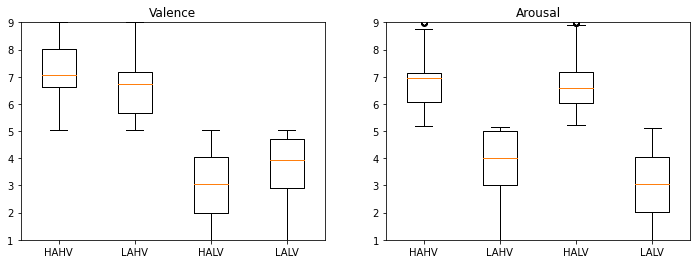

In [ ]:
# Valence and Arousal ratings between groups
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].set_title("Valence")
axs[0].set_ylim(1, 9)
axs[0].boxplot([df_hahv['Valence'], df_lahv['Valence'], df_halv['Valence'], df_lalv['Valence']], labels=['HAHV','LAHV','HALV', 'LALV'])

axs[1].set_title("Arousal")
axs[1].set_ylim(1, 9)
axs[1].boxplot([df_hahv['Arousal'], df_lahv['Arousal'], df_halv['Arousal'], df_lalv['Arousal']], labels=['HAHV','LAHV','HALV', 'LALV'])

{'boxes': [<matplotlib.lines.Line2D at 0x7fa12d64b590>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa12d654550>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa12d65b590>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fa12d65b050>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fa12d64ba90>,
  <matplotlib.lines.Line2D at 0x7fa12d665550>]}

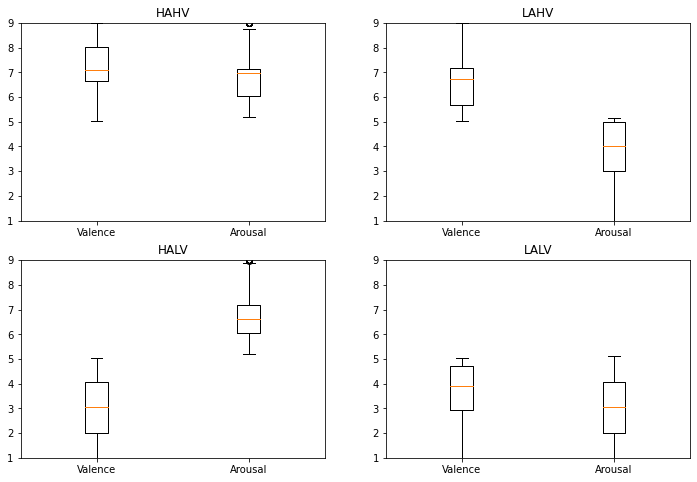

In [ ]:
# Valence and Arousal ratings per group
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].set_title("HAHV")
axs[0,0].set_ylim(1, 9)
axs[0,0].boxplot([df_hahv['Valence'], df_hahv['Arousal']], labels=['Valence','Arousal'])

axs[0,1].set_title("LAHV")
axs[0,1].set_ylim(1, 9)
axs[0,1].boxplot([df_lahv['Valence'], df_lahv['Arousal']], labels=['Valence','Arousal'])

axs[1,0].set_title("HALV")
axs[1,0].set_ylim(1, 9)
axs[1,0].boxplot([df_halv['Valence'], df_halv['Arousal']], labels=['Valence','Arousal'])

axs[1,1].set_title("LALV")
axs[1,1].set_ylim(1, 9)
axs[1,1].boxplot([df_lalv['Valence'], df_lalv['Arousal']], labels=['Valence','Arousal'])

#### One hot 编码

In [ ]:
# Function to check if each trial has positive or negative valence
def positive_valence(trial):
    return 1 if labels[trial,0] >= np.median(labels[:,0]) else 0 
# Function to check if each trial has high or low arousal
def high_arousal(trial):
    return 1 if labels[trial,1] >= np.median(labels[:,1]) else 0

In [ ]:
# Convert all ratings to boolean values
labels_encoded = []
for i in range (len(labels)):
  labels_encoded.append([positive_valence(i), high_arousal(i)])
labels_encoded = np.reshape(labels_encoded, (trials, 2))
df_labels = pd.DataFrame(data=labels_encoded, columns=["Positive Valence", "High Arousal"])
print(df_labels.describe())

       Positive Valence  High Arousal
count       1240.000000   1240.000000
mean           0.533065      0.500000
std            0.499107      0.500202
min            0.000000      0.000000
25%            0.000000      0.000000
50%            1.000000      0.500000
75%            1.000000      1.000000
max            1.000000      1.000000


In [ ]:
# Dataset with only Valence column
df_valence = df_labels['Positive Valence']
# Dataset with only Arousal column
df_arousal = df_labels['High Arousal']

## EEG数据

### 分离EEG数据与非EEG数据
该数据集包含 32 个脑电图通道和 8 个外部生理信号通道。

In [ ]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [ ]:
eeg_data = []
for i in range (len(data)):
  for j in range (len(eeg_channels)):
    eeg_data.append(data[i,j])
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

(1240, 32, 8064)


In [ ]:
peripheral_data = []
for i in range (len(data)):
  for j in range (32,len(data[0])):
    peripheral_data.append(data[i,j])
peripheral_data = np.reshape(peripheral_data, (len(data), len(peripheral_channels), len(data[0,0])))
print(peripheral_data.shape)

(1240, 8, 8064)


### Welch特征提取
对于脑电图数据，我们采用Welch方法为每个电极提取θ波、α波、β波和γ波的频谱功率。所使用的频段为：
θ波（4 - 8 赫兹），α波（8 - 12 赫兹），β波（12 - 30 赫兹），以及γ波（30 - 64 赫兹）。

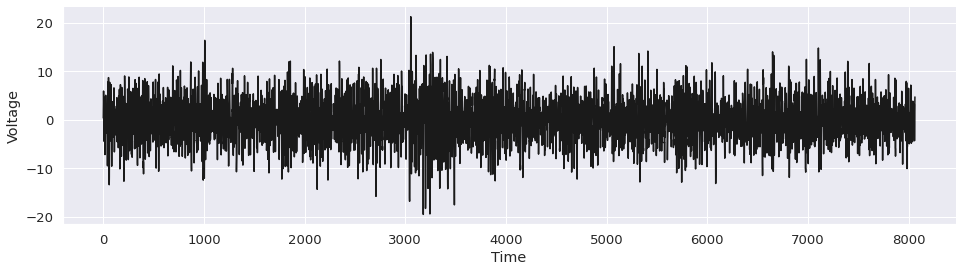

In [ ]:
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 128.
time = np.arange(eeg_data.size) / sf

# Plot the signal of first trial, last channel 
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(eeg_data[0,31], lw=1.5, color='k') 
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()

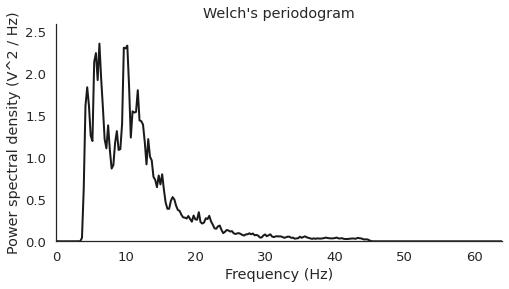

In [ ]:
# Define window length (4 seconds)
win = 4 * sf
freqs, psd = signal.welch(eeg_data[0,31], sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

#### Theta band power

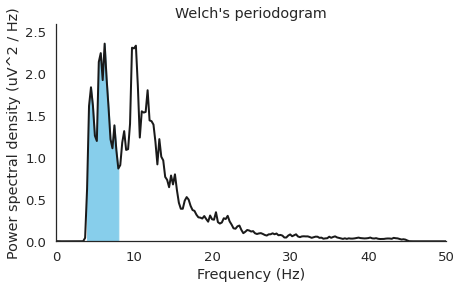

In [ ]:
# Define theta lower and upper limits
low, high = 4, 8

# Find intersecting values in frequency vector
idx_theta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the theta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_theta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Alpha band power

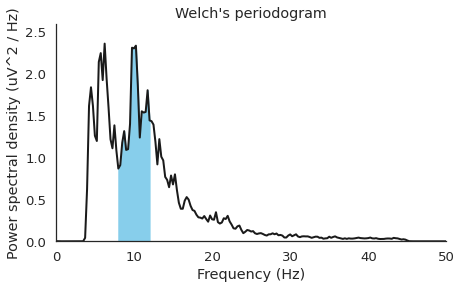

In [ ]:
# Define alpha lower and upper limits
low, high = 8, 12

# Find intersecting values in frequency vector
idx_alpha = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the alpha area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_alpha, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Beta band power

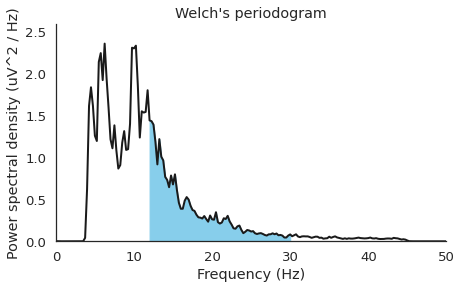

In [ ]:
# Define beta lower and upper limits
low, high = 12, 30

# Find intersecting values in frequency vector
idx_beta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the beta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_beta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Gamma band power

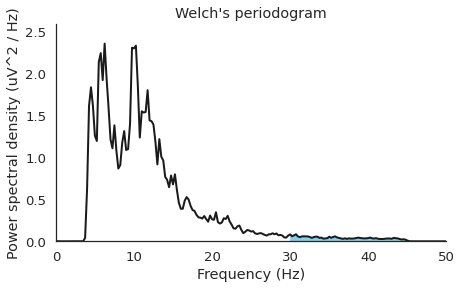

In [ ]:
# Define delta lower and upper limits
low, high = 30, 64

# Find intersecting values in frequency vector
idx_gamma = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the gamma area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_gamma, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

### 计算频段功率值

In [ ]:
"""Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
def bandpower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [ ]:
def get_band_power(trial, channel, band):
  bd = (0,0)

  if (band == "theta"): # drownsiness, emotional connection, intuition, creativity
    bd = (4,8)
  elif (band == "alpha"): # reflection, relaxation
    bd = (8,12)
  elif (band == "beta"): # concentration, problem solving, memory
    bd = (12,30)
  elif (band == "gamma"): # cognition, perception, learning, multi-tasking
    bd = (30,64)
  
  return bandpower(eeg_data[trial,channel], 128, bd)

print(get_band_power(0,31,"theta"))
print(get_band_power(0,31,"alpha"))
print(get_band_power(0,31,"beta"))
print(get_band_power(0,31,"gamma"))

5.434119660168186
5.369595513295194
6.286556266834863
0.9879159580139809


### 对包含 6 个脑电图区域和 4 种频段功率值的数据集进行处理

In [ ]:
# Transform 880 x 32 x 8064 => 880 x 128
eeg_band_arr = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_band_arr.append(get_band_power(i,j,"theta"))
    eeg_band_arr.append(get_band_power(i,j,"alpha"))
    eeg_band_arr.append(get_band_power(i,j,"beta"))
    eeg_band_arr.append(get_band_power(i,j,"gamma"))
eeg_band_arr = np.reshape(eeg_band_arr, (trials, 128))

脑电图通道根据其在大脑中的空间位置被分为 6 个组别。 We combine the temmporal-left and temporal-right channels into the left and right groups. The frontal group only includes the fronto-central channels. All centro-parietal channels are included in the central group.

In [ ]:
left = np.array(["Fp1", "AF3", "F7", "FC5", "T7"])
right = np.array(["Fp2", "AF4", "F8", "FC6", "T8"])
frontal = np.array(["F3", "FC1", "Fz", "F4", "FC2"])
parietal = np.array(["P3", "P7", "Pz", "P4", "P8"])
occipital = np.array(["O1", "Oz", "O2", "PO3", "PO4"])
central = np.array(["CP5", "CP1", "Cz", "C4", "C3", "CP6", "CP2"])

#### Dataframe for Theta power values

In [ ]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_theta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_theta.append(get_band_power(i,j,"theta"))
eeg_theta = np.reshape(eeg_theta, (trials, 32))

df_theta = pd.DataFrame(data = eeg_theta, columns=eeg_channels)
print(df_theta.describe())

                Fp1           AF3  ...           PO4            O2
count  1.240000e+03  1.240000e+03  ...  1.240000e+03  1.240000e+03
mean   5.339087e+02  9.997425e+02  ...  7.807675e+02  3.364190e+02
std    1.180278e+03  3.194707e+03  ...  1.829198e+03  1.096779e+03
min    2.895855e-12  5.217485e-12  ...  5.862282e-12  5.181077e-12
25%    2.539066e+01  1.650062e+01  ...  2.260687e+01  1.917834e+01
50%    6.883789e+01  7.828812e+01  ...  6.720244e+01  5.083108e+01
75%    3.495724e+02  3.066706e+02  ...  4.101276e+02  1.175337e+02
max    1.552414e+04  3.812287e+04  ...  1.716702e+04  1.231403e+04

[8 rows x 32 columns]


In [ ]:
# Only print central channels
print(df_theta[central].head(5)) 

            CP5           CP1  ...           CP6           CP2
0  2.881030e-12  1.102969e-11  ...  3.026707e-12  3.933774e-12
1  3.869735e-11  3.822071e-11  ...  2.117855e-11  6.831691e-12
2  3.711943e+00  1.890259e+00  ...  2.503685e+00  1.974655e+00
3  4.004765e+00  1.883543e+00  ...  2.529543e+00  1.736048e+00
4  1.857737e+00  1.447578e+00  ...  1.496299e+00  1.577524e+00

[5 rows x 7 columns]


#### Dataframe for Alpha power values

In [ ]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_alpha = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_alpha.append(get_band_power(i,j,"alpha"))
eeg_alpha = np.reshape(eeg_alpha, (trials, 32))

df_alpha = pd.DataFrame(data = eeg_alpha, columns=eeg_channels)
print(df_alpha.describe())

                Fp1           AF3  ...           PO4            O2
count  1.240000e+03  1.240000e+03  ...  1.240000e+03  1.240000e+03
mean   1.789859e+02  3.419246e+02  ...  2.705077e+02  1.295847e+02
std    3.831952e+02  1.074560e+03  ...  6.064432e+02  4.063866e+02
min    8.517343e-12  2.410982e-11  ...  2.110533e-11  1.475856e-11
25%    1.550818e+01  1.046497e+01  ...  1.330757e+01  1.054236e+01
50%    3.595611e+01  3.360068e+01  ...  2.768816e+01  2.473084e+01
75%    1.308760e+02  1.195315e+02  ...  1.480190e+02  4.789017e+01
max    5.627907e+03  1.238070e+04  ...  5.542263e+03  3.966715e+03

[8 rows x 32 columns]


In [ ]:
# Only print occipital channels
print(df_alpha[occipital].head(5)) 

             O1            Oz            O2           PO3           PO4
0  1.958276e-11  1.063586e-11  1.475856e-11  2.995791e-11  2.110533e-11
1  4.541230e-11  5.876929e-11  1.456718e-10  1.336689e-10  2.411633e-10
2  6.263437e+00  5.958844e+00  8.209320e+00  7.656804e+00  9.179372e+00
3  5.632504e+00  5.341003e+00  6.541218e+00  6.627711e+00  6.922430e+00
4  4.457119e+00  4.057350e+00  5.195625e+00  5.767454e+00  5.225959e+00


#### Dataframe for Beta power values

In [ ]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_beta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_beta.append(get_band_power(i,j,"beta"))
eeg_beta = np.reshape(eeg_beta, (trials, 32))

df_beta = pd.DataFrame(data = eeg_beta, columns=eeg_channels)
print(df_beta.describe())

                Fp1           AF3  ...           PO4            O2
count  1.240000e+03  1.240000e+03  ...  1.240000e+03  1.240000e+03
mean   9.488065e+01  2.060151e+02  ...  1.500450e+02  9.334864e+01
std    1.783374e+02  6.780525e+02  ...  3.347954e+02  2.791958e+02
min    2.388058e-10  9.313548e-09  ...  2.053303e-09  8.740311e-10
25%    1.928663e+01  1.295291e+01  ...  1.343144e+01  1.152664e+01
50%    3.558689e+01  2.760957e+01  ...  2.259960e+01  2.035725e+01
75%    8.575883e+01  1.100701e+02  ...  9.089848e+01  3.653121e+01
max    3.528485e+03  5.784160e+03  ...  2.516334e+03  2.454760e+03

[8 rows x 32 columns]


In [ ]:
# Only print frontal channels
print(df_beta[frontal].head(5)) 

             F3           FC1            Fz            F4           FC2
0  1.064947e-08  5.310574e-09  2.966548e-09  1.301296e-09  1.937739e-09
1  3.288307e-08  2.519619e-08  3.693918e-08  4.365469e-08  2.993975e-08
2  9.839357e+00  4.390210e+00  7.598063e+00  9.444911e+00  6.377253e+00
3  7.032711e+00  3.946574e+00  6.481246e+00  6.763315e+00  5.341841e+00
4  6.021147e+00  3.145262e+00  5.356596e+00  5.797735e+00  4.608033e+00


#### Dataframe for Gamma power values

In [ ]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_gamma = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_gamma.append(get_band_power(i,j,"gamma"))
eeg_gamma = np.reshape(eeg_gamma, (trials, 32))

df_gamma = pd.DataFrame(data = eeg_gamma, columns=eeg_channels)
print(df_gamma.describe())

                Fp1           AF3  ...           PO4            O2
count  1.240000e+03  1.240000e+03  ...  1.240000e+03  1.240000e+03
mean   5.208486e+01  1.547094e+02  ...  8.336731e+01  5.747634e+01
std    1.375225e+02  6.555388e+02  ...  2.771627e+02  2.063313e+02
min    5.683412e-09  8.261575e-08  ...  4.047859e-08  2.392527e-08
25%    8.981479e+00  5.469742e+00  ...  4.453331e+00  4.435112e+00
50%    1.908935e+01  1.366659e+01  ...  9.809880e+00  7.323098e+00
75%    4.097494e+01  4.724009e+01  ...  4.117456e+01  1.509162e+01
max    3.213256e+03  6.060540e+03  ...  2.505826e+03  1.794802e+03

[8 rows x 32 columns]


In [ ]:
# Only print parietal channels
print(df_gamma[parietal].head(5)) 

             P3            P7            Pz            P4            P8
0  1.807680e-08  1.430477e-08  4.173796e-08  6.907498e-08  6.513504e-08
1  9.428286e-07  1.790268e-07  2.180208e-07  1.251983e-06  8.399015e-07
2  1.405996e+00  2.340776e+00  6.149348e-01  1.759804e+00  1.651851e+00
3  1.127093e+00  1.381447e+00  5.556367e-01  1.406085e+00  8.040019e-01
4  1.031171e+00  1.626731e+00  5.353514e-01  1.275852e+00  1.514359e+00


### 保存/加载计算所得的数据框

In [4]:
output_folder = 'gdrive/MyDrive/study/22997/out4/'

In [ ]:
df_arousal.to_pickle(output_folder + 'df_arousal.plk')
df_valence.to_pickle(output_folder + 'df_valence.plk')
df_theta.to_pickle(output_folder + 'df_theta.plk')
df_alpha.to_pickle(output_folder + 'df_alpha.plk')
df_beta.to_pickle(output_folder + 'df_beta.plk')
df_gamma.to_pickle(output_folder + 'df_gamma.plk')

In [5]:
df_arousal = pd.read_pickle(output_folder + 'df_arousal.plk')
df_valence = pd.read_pickle(output_folder + 'df_valence.plk')
df_theta = pd.read_pickle(output_folder + 'df_theta.plk')
df_alpha = pd.read_pickle(output_folder + 'df_alpha.plk')
df_beta = pd.read_pickle(output_folder + 'df_beta.plk')
df_gamma = pd.read_pickle(output_folder + 'df_gamma.plk')

# 建立Transformer模型

### 模型架构：
整体模型堆叠 4 个这样的 Transformer Block，每个Transformer Block包含两个子模块：  
(1)自注意力模块：LayerNorm → Multi-Head Attention（4 头，key_dim=128）→ Dropout → 残差连接  
(2)前馈模块：LayerNorm → Conv1D（作为逐位置的前馈层）→ Dropout → 激活函数 → Conv1D → 残差连接  
- GlobalAveragePooling1D（将序列特征压缩为固定维度向量）  
- MLP 层（全连接 + Dropout=0.4）  
- Softmax 输出层  

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    num_classes=2):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


#### 训练配置：
- 优化器：Adam，learning_rate = 1e-4
- 损失函数：sparse_categorical_crossentropy
- 评估指标：sparse_categorical_accuracy
- 早停：val_loss 不再下降时停止
- 训练轮数：最多 3000 epochs，batch_size = 128
#### 数据预处理（build_and_train）：
- 用 StandardScaler 对特征做 Z-score 标准化（零均值、单位方差）
- reshape 为 (样本数, 1, 特征数) 以适配 Transformer 的序列输入格式
- 按 80/20 比例划分训练集和测试集

In [10]:
head_size=128
num_heads=4
ff_dim=4
num_transformer_blocks=4
mlp_units=128
mlp_dropout=0.4
dropout=0.25
learning_rate = 1e-4
epochs = 3000
batch_size = 128

In [11]:
np.random.seed(123)
tf.random.set_seed(123)

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
tf.get_logger().setLevel('ERROR')

def build_and_train(x,y, verbose):  
  x = np.array(x)
  sc = StandardScaler()
  x = sc.fit_transform(x)
  x = x.reshape(x.shape[0], 1, x.shape[1])
  y = np.array(y)
  num_classes = len(np.unique(y))

  print("x.shape", x.shape, "y.shape", y.shape, "num_classes", num_classes)

  print("spliting the data to train and test")
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, shuffle=True, random_state=42)
  print("x_test.shape", x_test.shape)
  print("y_test.shape", y_test.shape)
  print("x_train.shape", x_train.shape)
  print("y_train.shape", y_train.shape)

  input_shape = x_train.shape[1:]
  print("input_shape:", input_shape)

  print("bulding the model")
  model = build_model(
    input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    mlp_units=[mlp_units],
    mlp_dropout=mlp_dropout,
    dropout=dropout,
    num_classes=num_classes,
  )

  model.compile(
      loss="sparse_categorical_crossentropy",
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=["sparse_categorical_accuracy"],
  )

  checkpoint_filepath = 'gdrive/MyDrive/study/22997/step1/mchk/'
  callbacks=tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_filepath,  monitor="val_sparse_categorical_accuracy", verbose=0,
    save_best_only=True, save_weights_only=False, mode="max", save_freq="epoch", restore_best_weights=True )
  
  print("starting fit")
  history=model.fit(
          x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,  
          verbose=verbose,
          validation_data=(x_test,y_test),
          callbacks=callbacks
          )
  
  print("model fit complete")
  
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  score = model.evaluate(x_train, y_train, verbose=0)
  print('Train loss:', score[0])
  print('Train accuracy:', score[1])

  return model, history.history


In [12]:
def plot_history(history, limit = None):
  fig, axs = plt.subplots(2, figsize=(15,12))
  
  p1 = np.array(history['sparse_categorical_accuracy'])
  p2 = np.array(history['val_sparse_categorical_accuracy'])
  p3 = np.array(history['loss'])
  p4 = np.array(history['val_loss'])

  if limit is not None:
    p1 = p1[0:limit]
    p2 = p2[0:limit]
    p3 = p3[0:limit]
    p4 = p4[0:limit]
       
  # train_max = p1.max()
  # axs[0].axhline(train_max, color='green')
  axs[0].plot(p1, label='train')

  # test_max = p2.max()
  # axs[0].axhline(test_max, color='red')
  axs[0].plot(p2, label='test')  
  
  axs[0].set_title('model accuracy')
  axs[0].legend(['train', 'test'], loc='lower right')

  axs[1].plot(p3, label='train')
  axs[1].plot(p4, label='test')

  axs[1].set_title('model loss')
  axs[1].legend(['train', 'test'], loc='upper left')


## 训练和测试模型

### Theta - Arousal

In [ ]:
x = df_theta
y = df_arousal
model, history = build_and_train(x, y, 0)

x.shape (1240, 1, 32) y.shape (1240,) num_classes 2
spliting the data to train and test
x_test.shape (248, 1, 32)
y_test.shape (248,)
x_train.shape (992, 1, 32)
y_train.shape (992,)
input_shape: (1, 32)
bulding the model
starting fit
model fit complete
Test loss: 0.7076668739318848
Test accuracy: 0.600806474685669
Train loss: 0.5651056170463562
Train accuracy: 0.6703628897666931


In [ ]:
prefix = "theta_arousal"
model = tf.keras.models.load_model(f'gdrive/MyDrive/study/22997/out3/{prefix}_model.h5')
history=np.load(f'gdrive/MyDrive/study/22997/out3/{prefix}_model_history.npy',allow_pickle='TRUE').item()

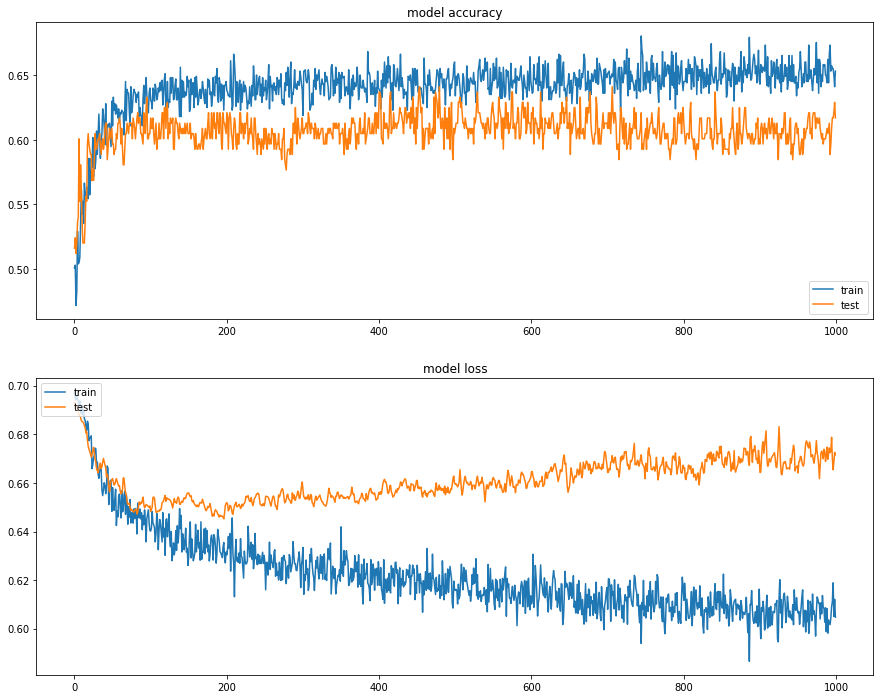

In [ ]:
plot_history(history, 1000)

In [ ]:
prefix = "theta_arousal"
model.save(f'gdrive/MyDrive/study/22997/out3/{prefix}_model.h5')
np.save(f'gdrive/MyDrive/study/22997/out3/{prefix}_model_history.npy', history)

### Theta - Valence

In [ ]:
x = df_theta
y = df_valence
model, history = build_and_train(x, y, 0)

x.shape (1240, 1, 32) y.shape (1240,) num_classes 2
spliting the data to train and test
x_test.shape (248, 1, 32)
y_test.shape (248,)
x_train.shape (992, 1, 32)
y_train.shape (992,)
input_shape: (1, 32)
bulding the model
starting fit
model fit complete
Test loss: 0.6940726041793823
Test accuracy: 0.6129032373428345
Train loss: 0.5792158842086792
Train accuracy: 0.7026209831237793


In [ ]:
prefix = "theta_valence"
model = tf.keras.models.load_model(f'gdrive/MyDrive/study/22997/out3/{prefix}_model.h5')
history=np.load(f'gdrive/MyDrive/study/22997/out3/{prefix}_model_history.npy',allow_pickle='TRUE').item()

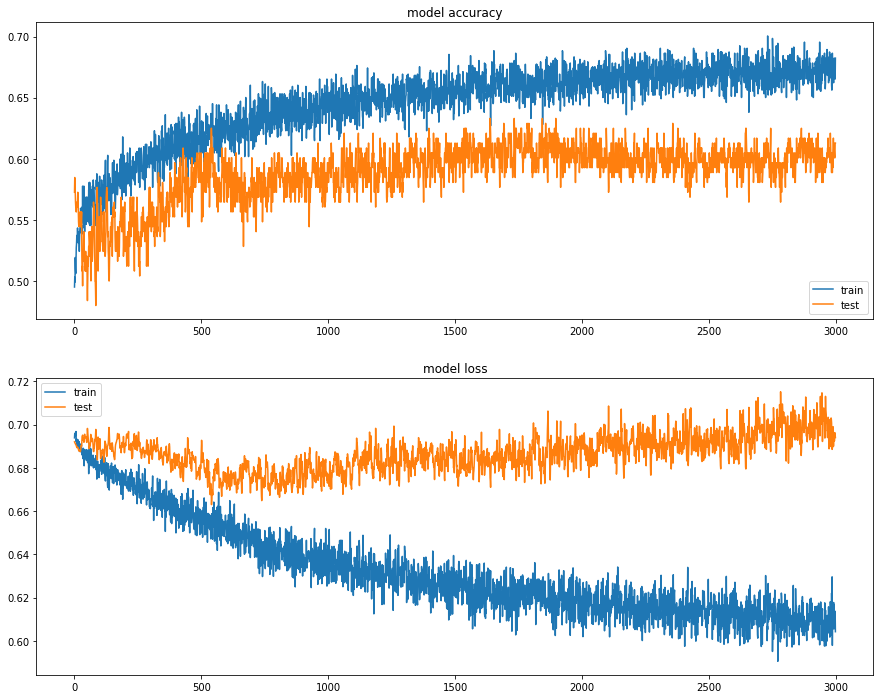

In [ ]:
plot_history(history)

In [ ]:
prefix = "theta_valence"
model.save(f'gdrive/MyDrive/study/22997/out3/{prefix}_model.h5')
np.save(f'gdrive/MyDrive/study/22997/out3/{prefix}_model_history.npy', history)

### Alpha - Arousal

In [ ]:
x = df_alpha
y = df_arousal
model, history = build_and_train(x, y, 0)

x.shape (1240, 1, 32) y.shape (1240,) num_classes 2
spliting the data to train and test
x_test.shape (248, 1, 32)
y_test.shape (248,)
x_train.shape (992, 1, 32)
y_train.shape (992,)
input_shape: (1, 32)
bulding the model
starting fit
model fit complete
Test loss: 0.710146963596344
Test accuracy: 0.6088709831237793
Train loss: 0.5516700744628906
Train accuracy: 0.7046371102333069


In [15]:
prefix = "alpha_arousal"
model = tf.keras.models.load_model(f'gdrive/MyDrive/study/22997/out3/{prefix}_model.h5')
history=np.load(f'gdrive/MyDrive/study/22997/out3/{prefix}_model_history.npy',allow_pickle='TRUE').item()

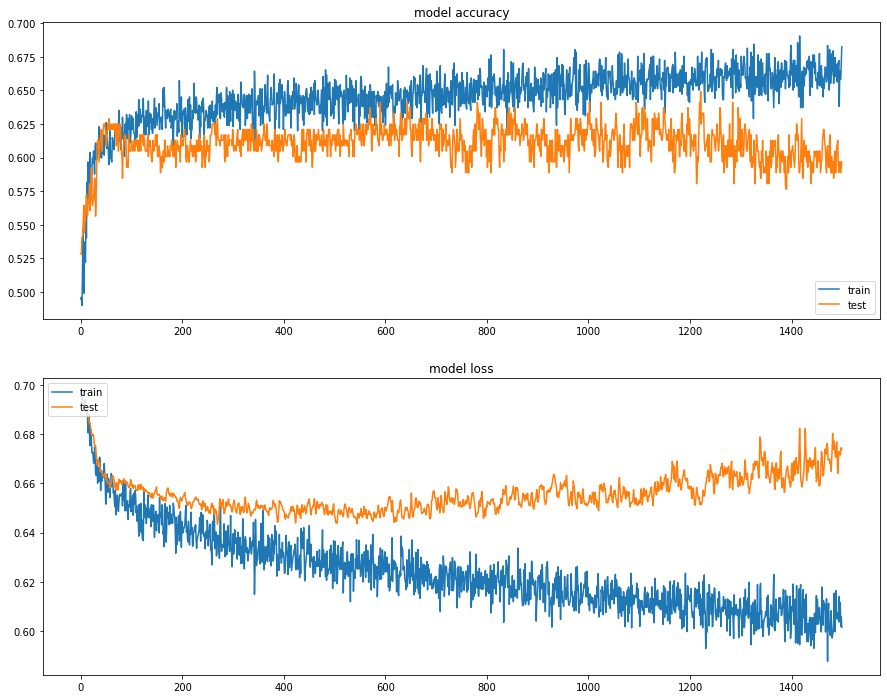

In [19]:
plot_history(history, 1500)

In [ ]:
prefix = "alpha_arousal"
model.save(f'gdrive/MyDrive/study/22997/out3/{prefix}_model.h5')
np.save(f'gdrive/MyDrive/study/22997/out3/{prefix}_model_history.npy', history)

### Alpha - Valence

In [ ]:
x = df_alpha
y = df_valence
model, history = build_and_train(x, y, 0)

x.shape (1240, 1, 32) y.shape (1240,) num_classes 2
spliting the data to train and test
x_test.shape (248, 1, 32)
y_test.shape (248,)
x_train.shape (992, 1, 32)
y_train.shape (992,)
input_shape: (1, 32)
bulding the model
starting fit
model fit complete
Test loss: 0.7036367654800415
Test accuracy: 0.625
Train loss: 0.5689205527305603
Train accuracy: 0.7207661271095276


In [ ]:
prefix = "alpha_valence"
model = tf.keras.models.load_model(f'gdrive/MyDrive/study/22997/out3/{prefix}_model.h5')
history=np.load(f'gdrive/MyDrive/study/22997/out3/{prefix}_model_history.npy',allow_pickle='TRUE').item()

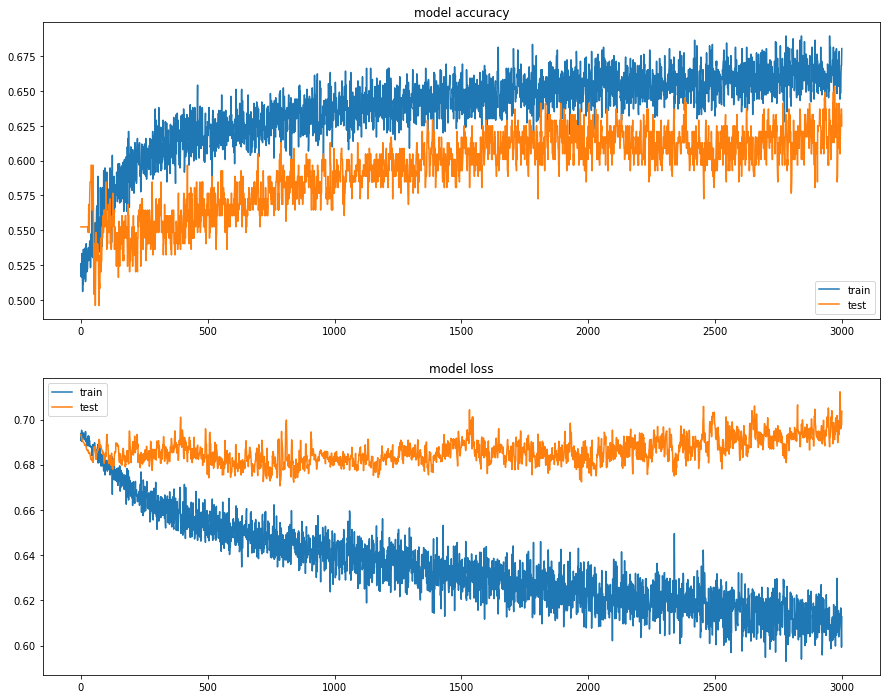

In [ ]:
plot_history(history)

In [ ]:
prefix = "alpha_valence"
model.save(f'gdrive/MyDrive/study/22997/out3/{prefix}_model.h5')
np.save(f'gdrive/MyDrive/study/22997/out3/{prefix}_model_history.npy', history)

### Beta - Arousal

In [ ]:
x = df_beta
y = df_arousal
model, history = build_and_train(x, y, 0)

x.shape (1240, 1, 32) y.shape (1240,) num_classes 2
spliting the data to train and test
x_test.shape (248, 1, 32)
y_test.shape (248,)
x_train.shape (992, 1, 32)
y_train.shape (992,)
input_shape: (1, 32)
bulding the model
starting fit
model fit complete
Test loss: 0.7307978868484497
Test accuracy: 0.6088709831237793
Train loss: 0.5476291179656982
Train accuracy: 0.7026209831237793


In [20]:
prefix = "beta_arousal"
model = tf.keras.models.load_model(f'gdrive/MyDrive/study/22997/out3/{prefix}_model.h5')
history=np.load(f'gdrive/MyDrive/study/22997/out3/{prefix}_model_history.npy',allow_pickle='TRUE').item()

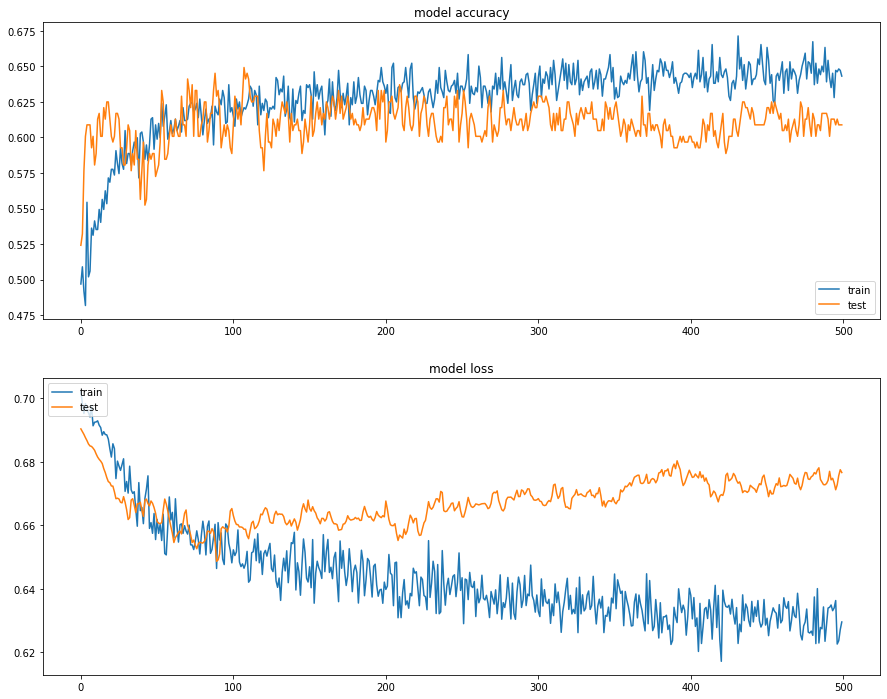

In [21]:
plot_history(history, 500)

In [ ]:
prefix = "beta_arousal"
model.save(f'gdrive/MyDrive/study/22997/out3/{prefix}_model.h5')
np.save(f'gdrive/MyDrive/study/22997/out3/{prefix}_model_history.npy', history)

### Beta - Valence

In [ ]:
x = df_beta
y = df_valence
model, history = build_and_train(x, y, 0)

x.shape (1240, 1, 32) y.shape (1240,) num_classes 2
spliting the data to train and test
x_test.shape (248, 1, 32)
y_test.shape (248,)
x_train.shape (992, 1, 32)
y_train.shape (992,)
input_shape: (1, 32)
bulding the model
starting fit
model fit complete
Test loss: 0.7014478445053101
Test accuracy: 0.6330645084381104
Train loss: 0.5631062984466553
Train accuracy: 0.6824596524238586


In [ ]:
prefix = "beta_valence"
model = tf.keras.models.load_model(f'gdrive/MyDrive/study/22997/out3/{prefix}_model.h5')
history=np.load(f'gdrive/MyDrive/study/22997/out3/{prefix}_model_history.npy',allow_pickle='TRUE').item()

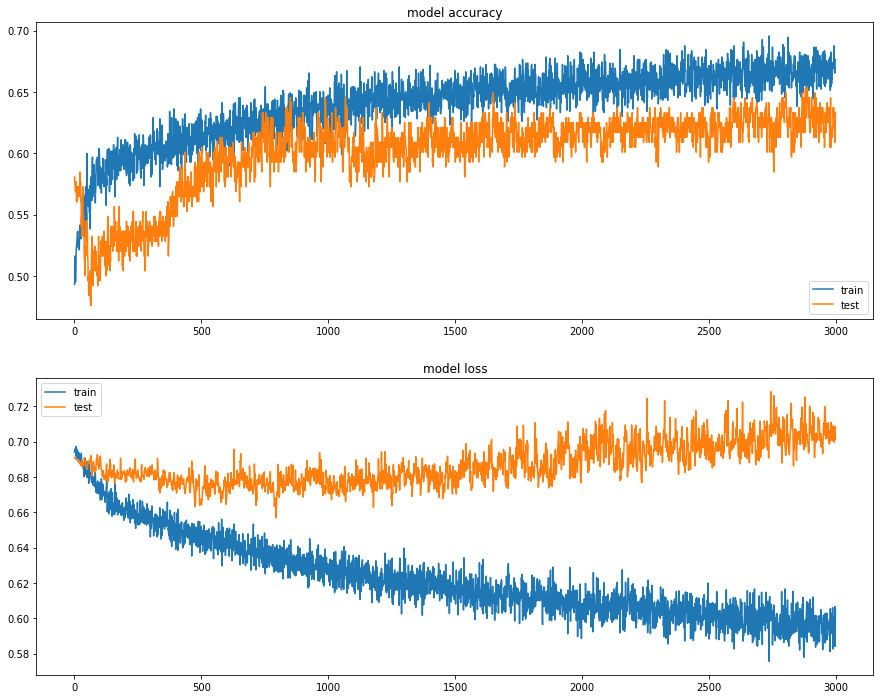

In [ ]:
plot_history(history)

In [ ]:
prefix = "beta_valence"
model.save(f'gdrive/MyDrive/study/22997/out3/{prefix}_model.h5')
np.save(f'gdrive/MyDrive/study/22997/out3/{prefix}_model_history.npy', history)

### Gamma - Arousal

In [ ]:
x = df_gamma
y = df_arousal
model, history = build_and_train(x, y, 0)

x.shape (1240, 1, 32) y.shape (1240,) num_classes 2
spliting the data to train and test
x_test.shape (248, 1, 32)
y_test.shape (248,)
x_train.shape (992, 1, 32)
y_train.shape (992,)
input_shape: (1, 32)
bulding the model
starting fit
model fit complete
Test loss: 0.7649006843566895
Test accuracy: 0.6048387289047241
Train loss: 0.5442216396331787
Train accuracy: 0.7096773982048035


In [ ]:
prefix = "gamma_arousal"
model = tf.keras.models.load_model(f'gdrive/MyDrive/study/22997/out3/{prefix}_model.h5')
history=np.load(f'gdrive/MyDrive/study/22997/out3/{prefix}_model_history.npy',allow_pickle='TRUE').item()

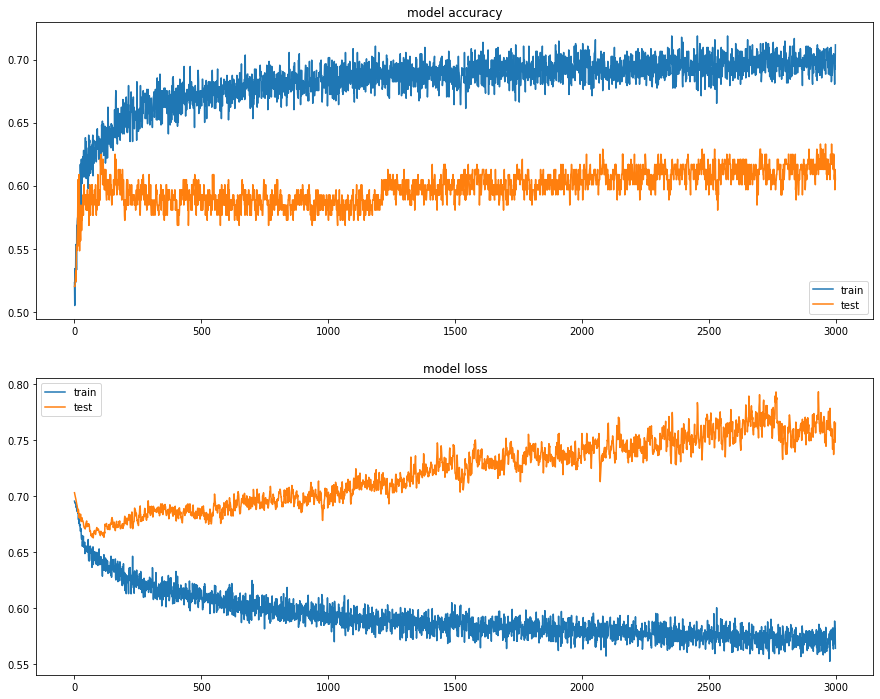

In [ ]:
plot_history(history)

In [ ]:
prefix = "gamma_arousal"
model.save(f'gdrive/MyDrive/study/22997/out3/{prefix}_model.h5')
np.save(f'gdrive/MyDrive/study/22997/out3/{prefix}_model_history.npy', history)

### Gamma - Valence

In [ ]:
x = df_gamma
y = df_valence
model, history = build_and_train(x, y, 0)

x.shape (1240, 1, 32) y.shape (1240,) num_classes 2
spliting the data to train and test
x_test.shape (248, 1, 32)
y_test.shape (248,)
x_train.shape (992, 1, 32)
y_train.shape (992,)
input_shape: (1, 32)
bulding the model
starting fit
model fit complete
Test loss: 0.8501830101013184
Test accuracy: 0.6129032373428345
Train loss: 0.5030157566070557
Train accuracy: 0.7268145084381104


In [ ]:
prefix = "gamma_valence"
model = tf.keras.models.load_model(f'gdrive/MyDrive/study/22997/out3/{prefix}_model.h5')
history=np.load(f'gdrive/MyDrive/study/22997/out3/{prefix}_model_history.npy',allow_pickle='TRUE').item()

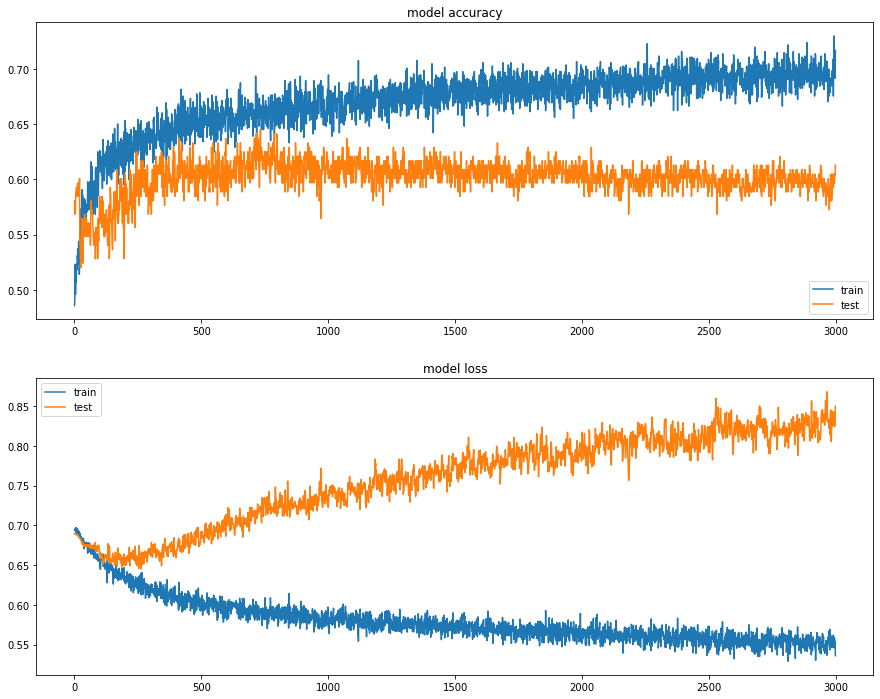

In [ ]:
plot_history(history)

In [ ]:
prefix = "gamma_valence"
model.save(f'gdrive/MyDrive/study/22997/out3/{prefix}_model.h5')
np.save(f'gdrive/MyDrive/study/22997/out3/{prefix}_model_history.npy', history)